<a href="https://colab.research.google.com/github/ThierrryScotto/fer_recognition_using_frequency_neural_network/blob/master/basic_FreNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [5]:
pip install scipy

In [6]:
pip install -q pillow

In [7]:
pip install -q dlib

In [8]:
pip install -q face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from PIL import Image
from scipy.fftpack import dct

# Importing dataset

In [ ]:
# df_ck_plus = pd.read_csv('./Datasets/ckextended.csv')
URL = "https://raw.githubusercontent.com/ThierrryScotto/fer_recognition_using_frequency_neural_network/master/datasets/ckextended.csv"
df_ck_plus = pd.read_csv(URL)
df_ck_plus

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training
...,...,...,...
915,5,87 86 88 92 92 127 231 248 251 253 254 254 254...,PrivateTest
916,5,21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...,PrivateTest
917,5,76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...,PrivateTest
918,5,114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...,PrivateTest


## Download of shape_predictor

In [ ]:
import os
import bz2

# URL do arquivo shape_predictor_68_face_landmarks.dat.bz2
url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

# Caminho para salvar o arquivo compactado
compressed_dat_path = "/content/model/shape_predictor_68_face_landmarks.dat.bz2"

# Caminho para salvar o arquivo descompactado
dat_path = "/content/model/shape_predictor_68_face_landmarks.dat"

os.makedirs('/content/model/', exist_ok=False)

# Baixar o arquivo usando wget
!wget -O {compressed_dat_path} {url}

# Descompactar o arquivo
with bz2.BZ2File(compressed_dat_path) as f_in:
    with open(dat_path, 'wb') as f_out:
        f_out.write(f_in.read())

print(f"Arquivo descompactado salvo em: {dat_path}")

# Verificar se o arquivo foi descompactado corretamente
if os.path.exists(dat_path):
    print("Arquivo descompactado com sucesso!")
else:
    print("Falha ao descompactar o arquivo.")


--2024-07-28 19:41:15--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘/content/model/shape_predictor_68_face_landmarks.dat.bz2’

/content/model/shap 100%[===================>]  61.07M  44.5MB/s    in 1.4s    

2024-07-28 19:41:17 (44.5 MB/s) - ‘/content/model/shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Arquivo descompactado salvo em: /content/model/shape_predictor_68_face_landmarks.dat
Arquivo descompactado com sucesso!


## Converting 1D vectors to images

In [ ]:
HEIGHT = 48
WIDTH = 48
OUTPUT_FOLDER = '/content/images/input_images'
os.makedirs(OUTPUT_FOLDER, exist_ok=False)
OUTPUT_PATH = os.path.join(OUTPUT_FOLDER, 'reconstructed_image')

In [ ]:
df_ck_plus.shape

(920, 3)

In [ ]:
for index, row in df_ck_plus.iterrows():
  one_dimensional_str = row['pixels'].split()
  one_dimensional_vec = np.array(list(map(int, one_dimensional_str)))

  if one_dimensional_vec.size == HEIGHT * WIDTH:
    image_2d = one_dimensional_vec.reshape((HEIGHT, WIDTH))
    plt.imsave(f'{OUTPUT_PATH}_{index}.png', image_2d, cmap='gray')
  else:
    print()
    raise ValueError(f"The size of the vector {one_dimensional_vec.size} does not correspond to the product of the dimensions ({HEIGHT}, {WIDTH})")

#Image pre-processing

In [ ]:
import dlib
from PIL import Image
import numpy as np
import os

def adjust_and_crop_face(image_path, output_folder):
    # Carregar a imagem
    image = dlib.load_rgb_image(image_path)

    # Inicializar o detector de rostos e o preditor de pontos-chave
    detector = dlib.get_frontal_face_detector()

    # Caminho completo para o arquivo shape_predictor_68_face_landmarks.dat
    dat_file_path = '/content/model/shape_predictor_68_face_landmarks.dat'
    # Carregar o preditor de forma
    predictor = dlib.shape_predictor(dat_file_path)

    # Detectar os rostos na imagem
    faces = detector(image, 1)

    # Criar a pasta de saída, se não existir
    os.makedirs(output_folder, exist_ok=True)

    # Processar cada rosto detectado
    for i, face in enumerate(faces):
        # Obter os pontos chave do rosto
        landmarks = predictor(image, face)

        # Converter os pontos chave para um formato utilizável
        face_landmarks = {
            "left_eye": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(36, 42)],
            "right_eye": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(42, 48)],
            "left_eyebrow": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(17, 22)],
            "right_eyebrow": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(22, 27)],
            "chin": [(landmarks.part(j).x, landmarks.part(j).y) for j in range(0, 17)],
        }

        # Obter os pontos dos olhos, sobrancelhas e queixo
        left_eye = np.array(face_landmarks['left_eye'])
        right_eye = np.array(face_landmarks['right_eye'])
        left_eyebrow = np.array(face_landmarks['left_eyebrow'])
        right_eyebrow = np.array(face_landmarks['right_eyebrow'])
        chin = np.array(face_landmarks['chin'])

        # Calcular o ponto médio entre os olhos
        left_eye_center = left_eye.mean(axis=0)
        right_eye_center = right_eye.mean(axis=0)
        eye_center = ((left_eye_center + right_eye_center) / 2).astype(int)

        # Calcular o ângulo para horizontalizar os olhos
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dy, dx))

        # Rotacionar a imagem para horizontalizar os olhos
        pil_image = Image.fromarray(image)
        pil_image = pil_image.rotate(angle, center=tuple(eye_center), expand=True)

        # Recalcular os pontos chave após rotação
        rotated_image = np.array(pil_image)
        rotated_faces = detector(rotated_image, 1)
        rotated_landmarks = predictor(rotated_image, rotated_faces[0])

        # Obter os novos pontos chave para sobrancelhas e queixo
        left_eyebrow = np.array([(rotated_landmarks.part(j).x, rotated_landmarks.part(j).y) for j in range(17, 22)])
        right_eyebrow = np.array([(rotated_landmarks.part(j).x, rotated_landmarks.part(j).y) for j in range(22, 27)])
        chin = np.array([(rotated_landmarks.part(j).x, rotated_landmarks.part(j).y) for j in range(0, 17)])

        # Calcular o topo das sobrancelhas e o fundo do queixo
        top_of_eyebrows = min(left_eyebrow[:,1].min(), right_eyebrow[:,1].min())
        bottom_of_chin = chin[:,1].max()

        # Calcular as coordenadas do recorte
        top = top_of_eyebrows
        bottom = bottom_of_chin
        left = min(chin[:,0].min(), left_eyebrow[:,0].min(), right_eyebrow[:,0].min())
        right = max(chin[:,0].max(), left_eyebrow[:,0].max(), right_eyebrow[:,0].max())

        # Recortar a imagem
        cropped_face = pil_image.crop((left, top, right, bottom))

        # Salvar a imagem recortada com o nome original acrescido de "face"
        base_filename, ext = os.path.splitext(os.path.basename(image_path))
        face_image_path = os.path.join(output_folder, f'{base_filename}_face{ext}')
        cropped_face.save(face_image_path)
        print(f'Rosto {i+1} salvo em {face_image_path}')

# Caminho para a pasta de entrada
input_folder = '/content/images/input_images/'

# Pasta para salvar os rostos recortados
output_folder = '/content/images/preprocessed_images'

# Processar cada imagem na pasta de entrada
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        image_path = os.path.join(input_folder, filename)
        adjust_and_crop_face(image_path, output_folder)


Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_390_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_237_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_439_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_268_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_540_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_593_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_552_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_639_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_122_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_207_face.png
Rosto 1 salvo em /content/images/preprocessed_images/reconstructed_image_269_face.png
Rosto 1 salvo em /content/images/preprocessed_images/r

In [ ]:
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import shutil
# import os

# def copy_folder(src, dst):
#     # Criar a pasta de destino se não existir
#     os.makedirs(dst, exist_ok=True)

#     # Iterar sobre todos os arquivos e subpastas na pasta de origem
#     for item in os.listdir(src):
#         src_path = os.path.join(src, item)
#         dst_path = os.path.join(dst, item)

#         # Se for um diretório, fazer a cópia recursiva
#         if os.path.isdir(src_path):
#             copy_folder(src_path, dst_path)
#         else:
#             shutil.copy2(src_path, dst_path)

# # Caminho da pasta de origem no Colab
# # src_folder = '/content/images/preprocessed_images'
# src_folder = '/content/images/input_images'

# # Caminho da pasta de destino no Google Drive
# # dst_folder = '/content/drive/MyDrive/trabalho_processamento_imagem/preprocessed_images'
# dst_folder = '/content/drive/MyDrive/trabalho_processamento_imagem/input_images'

# # Copiar o conteúdo da pasta
# copy_folder(src_folder, dst_folder)

# print(f'Conteúdo copiado de {src_folder} para {dst_folder}')


Conteúdo copiado de /content/images/input_images para /content/drive/MyDrive/trabalho_processamento_imagem/input_images


# DCT and CIE Layer

Getting one image of example

In [1]:
def load_image_as_array(image_path):
    image = Image.open(image_path).convert('L')  # Load grayscale image
    return np.array(image)

In [9]:
# Caminhos das imagens
image_paths = [
    '/content/drive/MyDrive/trabalho_processamento_imagem/preprocessed_images/reconstructed_image_0_face.png',
    '/content/drive/MyDrive/trabalho_processamento_imagem/preprocessed_images/reconstructed_image_1_face.png',
    '/content/drive/MyDrive/trabalho_processamento_imagem/preprocessed_images/reconstructed_image_2_face.png',
    '/content/drive/MyDrive/trabalho_processamento_imagem/preprocessed_images/reconstructed_image_3_face.png',
    '/content/drive/MyDrive/trabalho_processamento_imagem/preprocessed_images/reconstructed_image_4_face.png',
    '/content/drive/MyDrive/trabalho_processamento_imagem/preprocessed_images/reconstructed_image_5_face.png',
    '/content/drive/MyDrive/trabalho_processamento_imagem/preprocessed_images/reconstructed_image_6_face.png',
]

# Lista para armazenar os arrays das imagens
image_arrays = []

# Carregar cada imagem e convertê-la em um array NumPy
for image_path in image_paths:
    if os.path.exists(image_path):
        image_array = load_image_as_array(image_path)
        image_arrays.append(image_array)
    else:
        print(f"Imagem não encontrada: {image_path}")

print(len(image_arrays))

7


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**using the gamma parameter to reduce the image size**

In [10]:
γ = 0.25

def resize_dct(dct_image, gamma):
    h, w = dct_image.shape
    new_h, new_w = int(h * gamma), int(w * gamma)
    return dct_image[:new_h, :new_w]

verificando a escala das imagens

In [ ]:
# for i, image_array in enumerate(image_arrays):
#     print(f"Forma da imagem {i}: {image_array.shape}")

# # Exibir a quantidade de imagens carregadas
# print(f"Total de imagens carregadas: {len(image_arrays)}")

In [11]:
frequency_input = []

for index in range(len(image_arrays)):
    transformed_image = dct(dct(image_arrays[index].T, norm='ortho').T, norm='ortho')
    frequency_input.append(resize_dct(transformed_image, γ))
    # frequency_input.append(dct(dct(image_arrays[index].T, norm='ortho').T, norm='ortho'))

print(frequency_input[0])

[[ 3.72383526e+03 -3.44326340e+02 -2.30385754e+01  7.59917893e+00
  -8.34164493e+01  1.52066168e+01 -1.86708417e+02  1.11492957e+02
   2.91823760e+00  8.82425553e+01]
 [-2.88763986e+02 -2.82724038e+02 -9.44295291e+01 -2.82699360e+02
   1.58901081e+02 -2.21847285e+02 -2.89764579e+02 -1.85962737e+02
  -1.27069177e+02 -1.05911573e+02]
 [-1.72231264e+02  2.24352394e+02 -7.22937204e+01  1.72610862e+02
   3.09199663e+02  2.14247838e+02  8.74025587e+00  1.34367857e+02
  -3.36740512e+01  6.89095936e+01]
 [-2.58464279e+02 -5.63159564e+01 -4.42567003e+01 -1.19371493e+02
  -2.07416436e+02 -5.45476975e+01 -5.88160763e+01  9.61698285e+00
  -6.85065647e+01  4.84519084e+01]
 [ 4.31677248e+00  4.24496551e+01 -9.70223345e+01  3.30290654e+01
   5.93772803e+01  3.01244436e+01  2.75365189e+01 -3.62521198e+01
  -3.07172160e+00 -5.75987171e+01]
 [ 3.88184883e+01  7.61617415e+00 -1.27861380e+02  2.82805798e+01
  -1.88841796e+02  6.86708969e+01 -2.95374381e+01  4.91549538e+01
   4.41905735e+01  7.66645209e+01

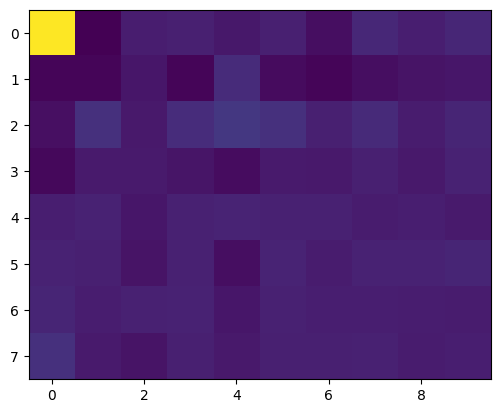

In [12]:
plt.imshow(frequency_input[0])
plt.show()

# Basic-FreNet

**Paremeters**

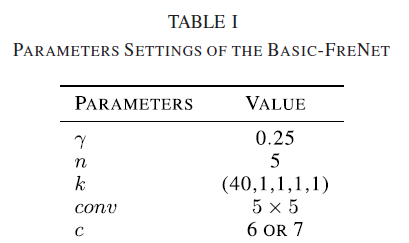

In [14]:
n = 5
k = [40, 1, 1, 1, 1]
conv = 5
c = 6

In [ ]:

# Função para criar uma camada convolucional com inicialização de distribuição normal truncada
def conv_layer(input_tensor, num_filters, kernel_size, name):
    with tf.variable_scope(name):
        in_channels = input_tensor.get_shape()[-1]
        weights = tf.get_variable('weights',
                                  shape=[kernel_size, kernel_size, in_channels, num_filters],
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        biases = tf.get_variable('biases',
                                 shape=[num_filters],
                                 initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_tensor, weights, strides=[1, 1, 1, 1], padding='SAME')
        output = tf.nn.relu(conv + biases)
    return output

# Placeholder para a entrada
# input_shape = (None, 40, 40, 1)  # Exemplo de entrada (ajustar conforme necessário)
# inputs = tf.placeholder(tf.float32, shape=input_shape)

# Camadas convolucionais conforme especificadas
conv1 = conv_layer(frequency_input, k[0], 5, 'conv1')
conv2 = conv_layer(conv1, k[1], 5, 'conv2')
conv3 = conv_layer(conv2, k[2], 5, 'conv3')
conv4 = conv_layer(conv3, k[3], 5, 'conv4')
conv5 = conv_layer(conv4, k[4], 5, 'conv5')

# Definir a sessão do TensorFlow
sess = tf.Session()

# Inicializar variáveis
sess.run(tf.global_variables_initializer())

# Exemplo de dados de entrada
input_data = np.random.random((1, 40, 40, 1))

# Fazer uma previsão
output_data = sess.run(conv5, feed_dict={inputs: input_data})
print("Output shape:", output_data.shape)


In [16]:
import tensorflow as tf

# Definindo a função de inicialização com distribuição normal truncada
def truncated_normal_init(shape, dtype=None):
    return tf.random.truncated_normal(shape, stddev=0.1, dtype=dtype)

# Parâmetros do modelo
n = 5
k = [40, 1, 1, 1, 1]
conv_kernel_size = 5
c = 6  # ou 7

# Placeholder para a entrada
# input_image = tf.keras.layers.Input(shape=(128, 128, 1))

# Construindo as camadas LMK com filtros de multiplicação
x = frequency_input
for filters in k:
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=(conv_kernel_size, conv_kernel_size),
        padding='same',
        kernel_initializer=truncated_normal_init)(x)

# Adicionando camada de convolução e pooling
x = tf.keras.layers.Conv2D(
    filters=c,
    kernel_size=(conv_kernel_size, conv_kernel_size),
    padding='same',
    kernel_initializer=truncated_normal_init)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Adicionando camadas totalmente conectadas para classificação
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(c, activation='softmax')(x)

# Definindo o modelo
model = tf.keras.Model(inputs=frequency_input, outputs=output)

# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


ValueError: Layer "conv2d" expects 1 input(s), but it received 7 input tensors. Inputs received: [<tf.Tensor: shape=(8, 10), dtype=float64, numpy=
array([[ 3.72383526e+03, -3.44326340e+02, -2.30385754e+01,
         7.59917893e+00, -8.34164493e+01,  1.52066168e+01,
        -1.86708417e+02,  1.11492957e+02,  2.91823760e+00,
         8.82425553e+01],
       [-2.88763986e+02, -2.82724038e+02, -9.44295291e+01,
        -2.82699360e+02,  1.58901081e+02, -2.21847285e+02,
        -2.89764579e+02, -1.85962737e+02, -1.27069177e+02,
        -1.05911573e+02],
       [-1.72231264e+02,  2.24352394e+02, -7.22937204e+01,
         1.72610862e+02,  3.09199663e+02,  2.14247838e+02,
         8.74025587e+00,  1.34367857e+02, -3.36740512e+01,
         6.89095936e+01],
       [-2.58464279e+02, -5.63159564e+01, -4.42567003e+01,
        -1.19371493e+02, -2.07416436e+02, -5.45476975e+01,
        -5.88160763e+01,  9.61698285e+00, -6.85065647e+01,
         4.84519084e+01],
       [ 4.31677248e+00,  4.24496551e+01, -9.70223345e+01,
         3.30290654e+01,  5.93772803e+01,  3.01244436e+01,
         2.75365189e+01, -3.62521198e+01, -3.07172160e+00,
        -5.75987171e+01],
       [ 3.88184883e+01,  7.61617415e+00, -1.27861380e+02,
         2.82805798e+01, -1.88841796e+02,  6.86708969e+01,
        -2.95374381e+01,  4.91549538e+01,  4.41905735e+01,
         7.66645209e+01],
       [ 7.88461366e+01, -1.94804947e+01,  3.27108240e+01,
         4.46637244e+01, -9.21697874e+01,  3.25271302e+01,
        -1.02315943e+01,  2.54954487e+00, -1.73422293e+01,
        -2.96146631e+01],
       [ 2.22205442e+02, -4.82768485e+01, -1.37179190e+02,
         9.90649609e+00, -6.08778554e+01,  7.79985735e+00,
         1.49534503e+01,  2.86045437e+01, -3.15052186e+01,
        -4.43002586e+00]])>, <tf.Tensor: shape=(8, 9), dtype=float64, numpy=
array([[ 6.16911897e+03, -7.14344485e+02, -6.88499986e+02,
        -1.19742176e+02, -3.59473788e+02, -2.13060026e+02,
        -3.41527997e+02,  2.06914030e+01, -1.35605787e+01],
       [ 3.02849216e+02, -8.59263848e-02,  3.75150237e+02,
        -2.17697315e+02,  4.98324111e+02, -2.18844358e+02,
        -1.61480622e+02, -1.85077583e+01,  7.44024647e+00],
       [-1.03745467e+03, -1.22981841e+01, -2.05790971e+02,
         6.13949181e+01,  4.19658547e+02, -8.34597277e+01,
        -2.49516674e+02, -1.06812803e+02,  5.85633153e+00],
       [-3.65262605e+02, -1.65012932e+02,  1.10409240e+02,
         1.66164964e+01, -1.48230410e+02, -1.72188189e+01,
         7.77984292e+00,  5.88634983e+01, -3.99724330e+01],
       [ 2.50711583e+02, -4.34523720e+01, -1.60971905e+01,
         1.31195721e+02, -1.29828303e+02, -5.66534686e+01,
         1.14364522e+02,  5.63509524e+01,  4.45094864e+00],
       [ 3.05042898e+02, -1.18129223e+02, -2.85244734e+02,
        -5.31817445e+00, -2.97442104e+02, -7.83479015e+00,
        -1.14748468e+01, -1.66068165e+01, -4.05988948e+01],
       [ 5.51229400e+02, -1.23261387e+02,  3.25833508e+01,
        -2.89775455e+00, -1.73668685e+02,  1.55456709e+00,
        -1.37082877e+02,  3.23674593e+01, -7.27251252e+01],
       [ 5.40319566e+02, -2.24009144e+01, -2.59054199e+02,
        -1.02646584e+01, -2.57029696e+02,  2.06148742e+01,
         5.03056972e+01, -6.50716212e+01, -1.52822167e+02]])>, <tf.Tensor: shape=(9, 10), dtype=float64, numpy=
array([[ 5.77190638e+03, -2.00007450e+02, -1.42806173e+03,
         1.25367199e+01, -7.30376224e+02, -9.39368438e+01,
        -5.13576855e+02, -3.01005826e+01, -4.38099531e+01,
         1.56403676e+01],
       [-3.50702874e+02,  3.27430724e+02,  3.12519661e+02,
         8.82973921e+01,  6.54053271e+02, -1.46514616e+02,
         6.24225586e+01, -2.26024838e+02,  6.70333878e+01,
        -1.62450318e+02],
       [-9.84352665e+02,  2.40909682e+02, -7.32149064e+02,
         1.37691824e+02,  2.74999557e+02,  4.17924555e+01,
        -1.51253502e+02, -4.58886662e+01, -4.01878564e+00,
        -4.07458626e+01],
       [-2.05326419e+02,  9.51487388e+01, -1.99801764e+02,
        -2.01058742e+01, -9.14743685e+01, -6.54110752e+01,
        -8.41821474e+01, -7.97892608e+01, -9.71870046e+01,
        -3.80329686e+01],
       [ 1.07840743e+02, -1.35786348e+01, -2.21913186e+02,
        -1.31105594e+00,  9.18413846e+01, -3.92878417e+01,
         1.69480968e+02, -5.02624040e+01,  1.40518999e+02,
        -4.65216607e+01],
       [ 1.66276745e+02, -2.82184794e+01,  4.76892982e+01,
        -3.38272027e+00, -2.63541996e+02, -1.60746639e+01,
        -8.20023263e-01,  1.08671983e+01,  1.07950877e+02,
         3.20947558e+01],
       [ 1.68540578e+02, -9.79724340e+01,  2.86447190e+01,
        -4.89280450e+01, -1.97424876e+02, -2.22232140e+01,
        -2.82871626e+01,  2.42254765e+00,  7.85556876e-01,
         2.20264249e+01],
       [ 3.01726030e+02, -7.10853911e+01, -1.28795271e+02,
        -7.58335493e+01, -4.25848399e+01, -3.31669238e+01,
         9.96877773e+01, -2.51444990e+01, -3.54102448e+01,
        -3.46172078e+01],
       [ 4.50505929e+01, -2.33253732e+01,  1.49569903e+02,
        -1.20911209e+01, -4.49409706e+01, -2.95040010e+01,
         8.55116504e+01, -2.73220137e+01, -2.59047388e+01,
        -9.17907842e+00]])>, <tf.Tensor: shape=(8, 9), dtype=float64, numpy=
array([[ 6.28481622e+03, -4.66501815e+02, -4.64308755e+02,
        -5.56621391e+01, -4.66265739e+02, -3.52174778e+01,
        -3.42773996e+02,  1.32578697e+02, -1.57596134e+02],
       [ 7.60576873e+02,  1.18350310e+01,  3.15628289e+02,
        -1.06380183e+02,  2.48413573e+02, -1.63154107e+02,
        -1.94447411e+02, -8.13455497e+01,  5.38430111e+01],
       [-7.50968691e+02, -2.75958065e+01, -3.38377154e+02,
         5.37240423e+01,  2.86731528e+02,  9.68253686e+01,
        -3.00694530e+02,  1.00060023e+01, -4.55031639e+01],
       [-1.69670617e+02, -7.36175282e+01,  1.59436657e+02,
        -1.70134133e-01, -1.00140675e+02,  6.18199187e+01,
        -2.77307199e+01, -1.43294274e+01, -4.66867811e+01],
       [-2.91466651e+01, -2.66730197e+01, -1.66533855e+02,
         6.66429010e+01, -2.82531096e+02,  5.91071033e+01,
         1.47563656e+02,  6.81913530e+00, -3.79993043e+01],
       [ 4.70167526e+02, -6.03762747e+01, -1.03463652e+02,
         1.23968976e+01, -3.66017789e+02,  3.25713679e+01,
        -2.43796204e+01,  3.53442649e+01,  3.49414576e+01],
       [ 2.36439277e+02, -1.52482995e+01, -2.96026225e+00,
         2.47253864e+00, -9.01771684e+01, -3.08039518e+01,
        -1.70481384e+02, -3.28291295e+01, -8.03513902e+01],
       [ 5.56096498e+02, -6.05072546e+00, -3.74749356e+02,
         4.15810815e+01, -6.92147869e+01,  1.10560240e+01,
         1.46709266e+02,  8.82340655e-01, -1.06247325e+02]])>, <tf.Tensor: shape=(8, 9), dtype=float64, numpy=
array([[ 5.26829679e+03, -5.67612640e+02, -2.41436098e+02,
        -9.31548388e+01, -2.00252362e+02, -6.09637206e+01,
        -2.09415491e+02,  4.08897397e+01, -8.01602850e+01],
       [ 4.73916087e+01, -5.13981485e+01,  2.04486915e+02,
        -1.50013185e+02,  4.22625325e+02, -1.62846245e+02,
        -1.51310433e+02, -4.89799928e+01,  1.62143510e+02],
       [-6.72402403e+02,  4.88801640e+01, -9.72564937e+01,
         8.45799619e+00,  5.82710887e+02, -4.01516678e+01,
        -2.61174060e+02, -1.03210194e+01, -7.23189676e+01],
       [-2.02457169e+02, -1.98682736e+01, -1.43804626e+01,
        -3.68983674e+01,  1.76455552e+01,  3.79864193e+00,
        -5.49220247e+01, -2.70200638e+01,  3.81409178e+01],
       [ 2.66568154e+01,  4.81767700e+01,  1.40235919e+02,
        -7.85228950e+00, -1.69620709e+02,  4.69320101e+01,
         7.98216752e+01, -2.49996178e+01,  4.14625392e+01],
       [ 3.90834376e+02,  3.00457265e+01, -6.47095284e+01,
         2.43785009e+01, -2.61614829e+02,  2.07858444e+01,
         5.56642012e+01, -1.24611652e+01, -2.09098708e+01],
       [ 3.77069675e+02,  8.34102678e-01,  7.03009390e+01,
        -3.16041597e+01, -1.84073086e+02,  4.47099107e-01,
        -6.70687146e+01,  3.14600409e+01, -5.99421263e+01],
       [ 4.64601053e+02, -4.30341172e+01, -3.37196923e+02,
         6.69601705e+01,  3.42710217e+01, -1.46503024e+01,
         3.27955210e+00,  7.51964187e+00, -7.50112966e+01]])>, <tf.Tensor: shape=(8, 9), dtype=float64, numpy=
array([[ 5.51140897e+03,  6.32505050e+01, -4.60856533e+02,
         8.32377418e+01, -2.35014610e+02,  1.82046969e+01,
        -2.41821007e+02,  1.99057800e+01, -1.39579007e+02],
       [ 2.76883100e+02, -1.53929035e+02,  1.47504283e+02,
        -1.69145617e+02,  2.30745379e+02,  1.05871263e+02,
        -1.87005925e+02,  1.66556458e+01, -9.55538649e+00],
       [-5.77707031e+02,  9.45631174e+01,  3.39613640e+01,
        -1.21849389e+02,  6.98634218e+02,  1.35317865e+02,
        -2.92185133e+00, -7.35271879e+01, -2.35575482e+01],
       [-6.35856404e+02, -9.94046216e+01, -1.70134910e+02,
        -5.03991997e+01, -1.06670503e+02,  3.68701234e+01,
        -1.28970305e+02,  9.75608528e+00, -5.60130547e+01],
       [ 1.54506333e+02,  6.73448713e+01,  1.62301647e+01,
         8.36105586e+01,  1.55020945e+01, -6.16918871e+01,
         1.56179239e+02, -4.73283481e+01,  2.77367219e+01],
       [ 1.13176670e+02, -2.21845422e+01, -3.90395144e+00,
         1.22258752e+02, -3.70863397e+02,  1.79912570e+01,
        -6.76888323e+01, -6.98437070e+01, -1.08176975e+01],
       [ 2.74593931e+02, -7.88529340e+01,  1.23377975e+01,
         3.33401673e+01, -1.90125034e+02, -4.05796531e+01,
        -1.40304653e+02, -4.78016671e+01, -8.41799319e+01],
       [ 4.68043310e+02,  7.26520030e+01, -2.42837116e+02,
         7.30668317e+01,  2.86124194e+01,  5.56557499e+01,
         3.47509832e+00,  4.39226577e+00, -2.55425285e+01]])>, <tf.Tensor: shape=(9, 9), dtype=float64, numpy=
array([[ 6.18431316e+03, -5.43098419e+02, -1.04000604e+03,
        -1.46323060e+02, -5.18941860e+02, -1.73319433e+02,
        -4.16142768e+02,  5.30992884e+01, -1.49268040e+02],
       [ 6.79176694e+02, -1.14928288e+02,  4.29447817e+02,
        -7.33476616e+01,  4.96051870e+02,  4.12081132e+01,
        -3.27123113e+02, -1.33731647e+00, -2.20913371e+01],
       [-1.14207626e+03,  8.18532802e+00, -5.95804974e+02,
        -3.37322735e+01,  5.42140050e+02,  5.10238167e+01,
        -7.79818282e+01, -3.01380658e+01,  5.01037233e+01],
       [-4.79240468e+02, -8.57874132e+01,  4.42269164e+01,
         5.56410731e+00, -3.67192502e+02,  1.04442552e+02,
        -2.14390138e+02,  5.92742880e+01, -8.91341146e+01],
       [ 6.81058076e+01,  2.70398662e+01, -2.43336277e+02,
        -6.24455014e+01, -8.71677645e+01, -5.52439702e+01,
         6.38183161e+01, -1.77473889e+01,  2.96598560e+01],
       [ 3.20432379e+02,  6.37855279e+01, -1.82844800e+02,
         5.53322502e+01, -3.66312112e+02,  7.28478177e+01,
        -1.55944272e+02,  1.23493905e+01,  2.47250043e+01],
       [ 3.45251363e+02,  4.95044109e+01, -7.40146056e+01,
        -4.41847201e+01, -1.36617897e+02, -2.15343714e+01,
         1.16114386e+01,  3.86438265e+01, -1.32452267e+02],
       [ 3.86336969e+02, -6.00733319e+01, -1.92719399e+02,
         5.32543179e+01, -1.75930155e+02, -1.02226191e+01,
         2.51435478e+02,  1.53062732e+01, -6.62428913e+01],
       [-1.98239897e+01,  4.06116290e+00,  1.23717875e+02,
        -2.98909351e+01, -7.58174417e+01,  1.20381039e+01,
         4.82335231e+01,  4.43686902e+01, -5.60907478e+01]])>]